In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- DL ----
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, RepeatVector, Dense

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils 

class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        x_reshape = x.contiguous().view(-1, x.size(-1)) 
        y = self.module(x_reshape)
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))
        return y

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.LSTM(
                               input_size = 1, 
                               hidden_size = 16, 
                               dropout = 0.25,
                               num_layers = 2,
                               bias = True,
                               batch_first = True,
                               bidirectional = True,
                               )
        self.decoder = nn.LSTM(
                               input_size = 32, 
                               hidden_size = 16, 
                               dropout = 0.25,
                               num_layers = 2,
                               bias = True,
                               batch_first = True,
                               bidirectional = True,
                               )
        self.fc = TimeDistributed(nn.Linear(32, 1))
                
    def forward(self, x):
        h0, (h_n, c_n) = self.encoder(x)
        h0, (h_n, c_n) = self.decoder(h0[:,-1:,:].repeat(1,5,1))
        out = self.fc(h0)
        return out


torch.nn.Module은 모든 뉴럴 네트워크 모듈의 기본 클래스입니다. 일반적인 모델들은 이 클래스를 상속받아야 합니다. 
모듈들은 다른 모듈을 또 포함할 수 있습니다. 이러한 중첩된 구조는 복잡한 아키텍처를 쉽게 구축하고 관리할 수 있습니다.

torch.nn.Module 은 PyTorch의 모든 Neural Network의 Base Class입니다. 
모듈은 다른 모듈을 포함할 수 있고, 트리 구조로 형성할 수 있습니다. 
nn 패키지는 신경망 계층(layer)과 거의 비슷한 Module 의 집합을 정의합니다. 
Module은 입력 텐서를 받고 출력 텐서를 계산하는 한편, 학습 가능한 매개변수를 갖는 텐서들을 내부 상태(internal state)로 갖습니다. 
nn 패키지는 또한 신경망을 학습시킬 때 주로 사용하는 유용한 손실 함수(loss function)들도 정의하고 있습니다.

## data

In [13]:
df = pd.read_csv('./data/SPY.csv',parse_dates=['Date'],index_col=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800


# 블로그

In [3]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
## Parameters

In [5]:
startdate="01/01/2015"
window_length = 10
encoding_dim = 3
epochs = 100
test_samples = 2000

## Utils

In [6]:
def mkdate(ts):
    return datetime.datetime.fromtimestamp(
        int(ts)
    ).strftime('%Y-%m-%d')

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")        

In [7]:
# get data
start_timestamp = time.mktime(datetime.datetime.strptime(startdate, "%d/%m/%Y").timetuple())
end_timestamp = int(time.time())
one_week = 3600*24*7 # s
one_day = 3600*24 # s
weeks = list(np.arange(start_timestamp, end_timestamp, one_week))
days_recorded = (datetime.datetime.fromtimestamp(end_timestamp)-datetime.datetime.fromtimestamp(start_timestamp)).days
print("days_recorded ",days_recorded)
data = []
if not os.path.isfile("data.pickle"):
    s = req.Session()
    r = s.get("https://www.coindesk.com/price/")
    for i in range(1, len(weeks)):
        start_weekday = mkdate(weeks[i-1])
        end_weekday = mkdate(weeks[i]-one_day)
        print(start_weekday, end_weekday)
        r = s.get("https://api.coindesk.com/charts/data?data=close&startdate={}&enddate={}&exchanges=bpi&dev=1&index=USD".format(start_weekday, end_weekday))
        ans = json.loads(r.text.replace("cb(", "").replace(");",""))["bpi"]
        ans.sort(key=lambda x: x[0])
        for pricepoint in ans:
            if pricepoint[0]/1000 >= weeks[i-1] and pricepoint[0]/1000 < (weeks[i]-one_day):
                data.append([int(pricepoint[0]/1000), pricepoint[1]])
                
    pickle.dump(data, open("./data.pickle", "wb"))
else:
    data = pickle.load(open("./data.pickle", "rb"))

df = pd.DataFrame(np.array(data)[:,1], columns=['price'])
df['pct_change'] = df.price.pct_change()
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))

scaler = MinMaxScaler()
x_train_nonscaled = np.array([df['log_ret'].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df['log_ret'])))])
x_train = np.array([scaler.fit_transform(df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df['log_ret'])))])

x_test = x_train[-test_samples:]
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

days_recorded  2866


100%|██████████████████████████████████████████████████████████████████████████| 48643/48643 [00:06<00:00, 7178.97it/s]


In [17]:
x_train.shape

(46643, 10, 1)

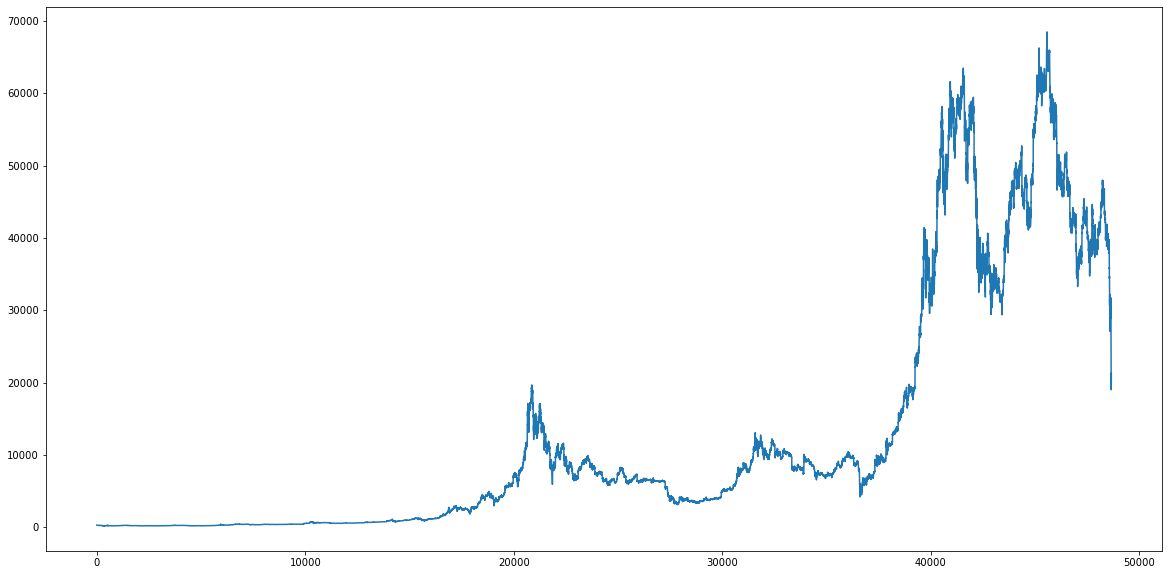

In [8]:
plt.figure(figsize=(20,10))
plt.plot(np.array(data)[:,1])

## Simple feedforward autoencoder

In [9]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# this is our input placeholder
input_window = Input(shape=(window_length,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_window)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(window_length, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
 dense_1 (Dense)             (None, 10)                40        
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
46/46 [==============================] - 0s 4ms/step - loss: 0.6940 - val_loss: 0.6909
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6882 - val_loss: 0.6855
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6822 - val_loss: 0.6789
Epoch 4/100
46/46 [=============

Epoch 75/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6128 - val_loss: 0.6104
Epoch 76/100
46/46 [==============================] - 0s 1ms/step - loss: 0.6128 - val_loss: 0.6104
Epoch 77/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6127 - val_loss: 0.6104
Epoch 78/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6127 - val_loss: 0.6104
Epoch 79/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6127 - val_loss: 0.6103
Epoch 80/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6126 - val_loss: 0.6103
Epoch 81/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6126 - val_loss: 0.6103
Epoch 82/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6126 - val_loss: 0.6103
Epoch 83/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6125 - val_loss: 0.6103
Epoch 84/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6125 - val_loss: 0.6102


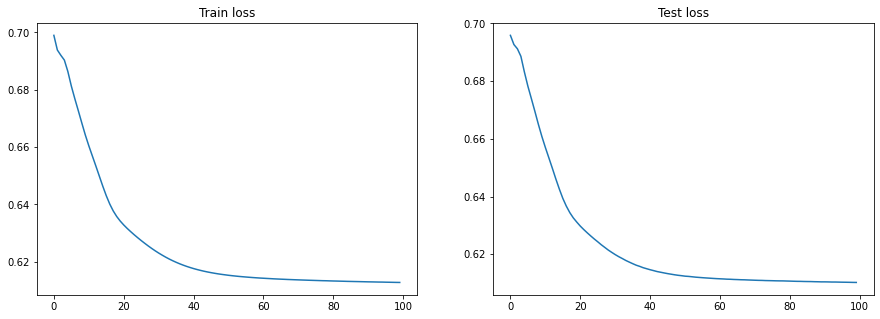

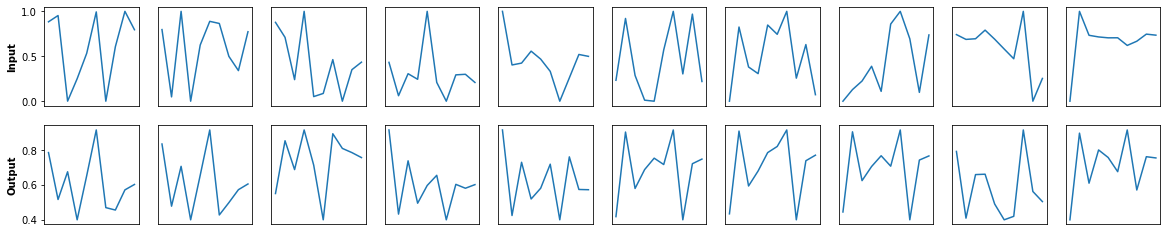

In [10]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder

In [11]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
 batch_normalization (BatchN  (None, 6)                24        
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 3)                 21        
                                                                 
 dense_4 (Dense)             (None, 6)                 24        
                                                                 
 batch_normalization_1 (Batc  (None, 6)                24        
 hNormalization)                                           

In [11]:
decoded_stocks.shape

(2000, 10)

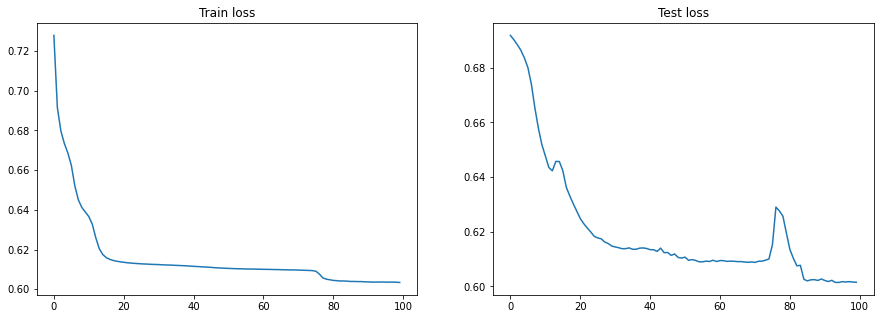

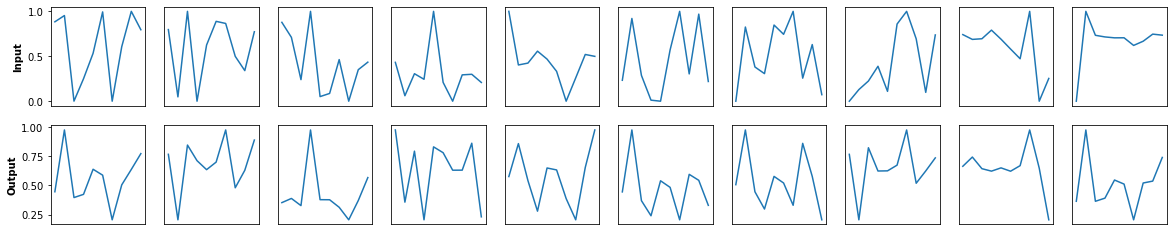

In [12]:
plot_history(history)
plot_examples(x_test_deep, decoded_stocks)

In [19]:
x_train_deep.shape

(46643, 10)

## 1D Convolutional autoencoder

In [14]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 10, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 1)              49        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 1)             0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 1)              4   

## LSTM autoencoder

In [ ]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)

## simple AE + augumention with synthetic data

In [ ]:
synthesized = []
required_nums = [0, 1]
optional_nums = list(np.arange(0.1, 0.9, 0.1))
for i in tqdm(range(100000)):
    combo = list(np.random.choice(optional_nums, 8))+required_nums
    np.random.shuffle(combo)
    synthesized.append(combo)

In [ ]:
x_train_simple = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

## Deep autoencoder + sythetic data

In [ ]:
x_train_deep = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)
autoencoder = Model(input_window, decoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)